Notebook used to generate supplemental figure S1

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import BootstrapFunctions as bsf
#sns.set_theme(context='talk',style='whitegrid')
plt.rcParams.update({"text.usetex": True})
idx = pd.IndexSlice
np.random.seed(0)

In [7]:
def lin_eta_xx(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*fy**2)/(1-fy-fx)**2
def lin_eta_yy(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*(1-fx)**2)/(1-fy-fx)**2
def lin_eta_xy(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*(1-fx)*fy)/(1-fy-fx)**2
def lin_rho(eta_ll,eta_gg,fy,fx):
    return lin_eta_xy(eta_ll,eta_gg,fy,fx)/np.sqrt(lin_eta_xx(eta_ll,eta_gg,fy,fx)*lin_eta_yy(eta_ll,eta_gg,fy,fx))
def lin_cvratio(eta_ll,eta_gg,fy,fx):
    return np.sqrt(lin_eta_xx(eta_ll,eta_gg,fy,fx)/lin_eta_yy(eta_ll,eta_gg,fy,fx))

In [8]:
#List out the perturbation types: u is up, d is down, n is none. l for lambda, g for gamma.  Add 1,2 to balance the neutral points
pertcases = {"lngn":[0,1,2],"lngu":[3,4,5],"lngd":[6,7,8],
             "lugn":[9,10,11],"lugu":[12,13,14],"lugd":[15,16,17],
             "ldgn":[18,19,20],"ldgu":[21,22,23],"ldgd":[24,25,26]}
oneparamperts = pertcases["lngn"]+pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]
no_nonperts = pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]
inv_pertcases = {v_int:k for k, v in pertcases.items() for v_int in v}
twovarparamlist = ['lambda','beta_x','gamma','beta_y','nx','Kx','ny','Ky','offset']
threevarparamlist = ['lambda','beta_x','gamma','beta_y','alpha','beta_z','nx','Kx','ny','Ky','offset']
byfilelist = ['fileN','fileda','filedb','sysname']

In [9]:
def nyneg1_nofx_det(df):
    a_coeff = df['beta_x']*df['gamma']/(df['beta_y']*df['lambda'])
    b_coeff = df['beta_x']*df['Ky']/df['lambda'] - (df['gamma']/df['beta_y'])*df['offset']
    c_coeff = -1*df['Ky']*(1+df['offset'])
    xvals = (-b_coeff+np.sqrt(b_coeff**2-4*a_coeff*c_coeff))/(2*a_coeff)
    res = pd.concat([xvals,df['gamma']*xvals/df['beta_y']],axis=1)
    res.columns = ['<x>','<y>']
    return res
def nypos1_nofx_det(df):
    a_coeff = df['beta_x']*df['gamma']/(df['beta_y'])
    b_coeff = df['beta_x']*df['Ky']-df['lambda']*(1+df['offset'])*df['gamma']/df['beta_y']
    c_coeff = -1*df['lambda']*df['Ky']*df['offset']
    xvals = (-b_coeff+np.sqrt(b_coeff**2-4*a_coeff*c_coeff))/(2*a_coeff)
    res = pd.concat([xvals,df['gamma']*xvals/df['beta_y']],axis=1)
    res.columns = ['<x>','<y>']
    return res
def no_fb_det(df):
    avgx = df['lambda']*df['offset']/(df['beta_x'])
    avgy = df['gamma']*avgx/df['beta_y']
    res = pd.concat([avgx,avgy],axis=1)
    res.columns = ['<x>','<y>']
    return res

def negdis_dep_cubsolv(p,q):
    delta = q**2/4+p**3/27
    u1 = -q/2+np.sqrt(delta)
    u2 = -q/2-np.sqrt(delta)
    return (u1)**(1/3)-(np.abs(u2))**(1/3)

def twovar_ny2_detsolve(df):
    a = df['beta_x']*(df['gamma']/df['beta_y'])**2
    b = 0
    c = df['beta_x']*df['Ky']**2
    d = -1*df['lambda']*df['Ky']**2
    xvals = pd.Series(negdis_dep_cubsolv(c/a,d/a),index=df.index)
    res = pd.concat([xvals,df['gamma']*xvals/df['beta_y']],axis=1)
    res.columns = ['<x>','<y>']
    return res



In [10]:
def rho_CV_analyse(systemdata,byfilelist = ['fileN','fileda','filedb','sysname']):
        byfile = systemdata.groupby(byfilelist)
        variances = byfile[['<x>','<y>']].var(ddof=0)
        means = byfile.mean()
        normcov = byfile[['<x>','<y>']].cov(ddof=0).reset_index(level=-1)
        normcov = normcov[normcov.iloc[:,0]=='<y>']['<x>']/(means['<x>']*means['<y>'])
        rhos = byfile[['<x>','<y>']].corr().reset_index(level=-1)
        rhos = rhos[rhos.iloc[:,0]=='<y>']['<x>']
        etas = variances/means[['<x>','<y>']]**2
        CVratios = np.sqrt(etas['<x>']/etas['<y>'])
        return {'means':means,'rhos':rhos,'CVratios':CVratios,
            'etas':etas,'normcov':normcov}
def linear_pred_rhocv(systemdata,byfilelist = ['fileN','fileda','filedb','sysname']):
    byfile = systemdata.groupby(byfilelist)
    means = byfile.mean()
    variances = byfile.var(ddof=0)
    pred_eta_xx = lin_eta_xx(variances['lambda']/means['lambda']**2,variances['gamma']/means['gamma']**2,
                             means['<F_y>'],means['<F_x>'])
    pred_eta_yy = lin_eta_yy(variances['lambda']/means['lambda']**2,variances['gamma']/means['gamma']**2,
                             means['<F_y>'],means['<F_x>'])
    pred_eta_xy = lin_eta_xy(variances['lambda']/means['lambda']**2,variances['gamma']/means['gamma']**2,
                             means['<F_y>'],means['<F_x>'])
    pred_rho_cv = pd.concat([pred_eta_xy,pred_eta_xx,pred_eta_yy],axis=1)
    pred_rho_cv.columns = ['eta_xy','eta_xx','eta_yy']
    pred_rho_cv['rhos'] = pred_rho_cv['eta_xy']/np.sqrt(pred_rho_cv['eta_xx']*pred_rho_cv['eta_yy'])
    pred_rho_cv['CVratios'] = np.sqrt(pred_rho_cv['eta_xx']/pred_rho_cv['eta_yy'])
    pred_rho_cv['eta_ll'] = variances['lambda']/means['lambda']**2
    pred_rho_cv['eta_gg']=variances['gamma']/means['gamma']**2
    pred_rho_cv[['<F_y>','<F_x>']] = means[['<F_y>','<F_x>']]
    return pred_rho_cv

In [11]:
folders = glob.glob('FiniteSampleTest/*/*')
dat = []
failedsims = []

for i,folder in enumerate(folders):
    files = glob.glob(folder+'/*[!meta]data.csv',recursive=True)
    for j,f in enumerate(files):
        data = pd.read_csv(f)
        data = data.reset_index()
        numstrings = f.split("/")[-1].split('-')
        data['samples'] = float(numstrings[1][1:])
        data['sysname'] = "/".join(f.split("/")[1:-1])
        data = data[(data[['Cov Bal xx','Cov Bal yy','Cov Bal xy']] < 0.05).all(axis=1)]
        dat.append(data)
analysed_data = pd.concat(dat)

#analysed_data = analysed_data[(analysed_data["filedb"]>=0.005)&(analysed_data["fileda"]>=0.005)]
pertdata = analysed_data.reset_index(drop=True).set_index(["sysname"])

In [12]:
pertdata[(pertdata['nx'] == 0)&(pertdata['ny']==-1)].sort_values(by='<F_y>',ascending=True)

,index,Exec Time,Sim Time,Steps,Flux Bal x,Flux Bal y,Cov Bal xx,Cov Bal xy,Cov Bal yy,lambda,...,Ky,offset,<x>,<y>,Var(x),Var(y),Cov(xy),<F_x>,<F_y>,samples
sysname,,,,,,,,,,,,,,,,,,,,,
12-27 1515/system_6,6839,13899,291933.0,61685700.0,0.000439,0.000313,0.003094,0.001295,0.000735,37.310800,...,10,0.001,34.287600,102.239000,19.869000,242.375000,47.077200,0.0,-0.899035,10000.0
12-27 1515/system_6,9017,13933,293630.0,61676700.0,0.002304,0.000090,0.005790,0.001483,0.001424,36.887500,...,10,0.001,33.998600,101.610000,19.647200,240.683000,46.642600,0.0,-0.898573,10000.0
12-27 1515/system_6,2346,13767,291505.0,61181000.0,0.000945,0.000039,0.010010,0.000055,0.001809,37.125100,...,10,0.001,34.360700,101.506000,20.005400,239.964000,47.014200,0.0,-0.898497,10000.0
12-27 1515/system_6,6242,13883,294163.0,61642900.0,0.001754,0.000228,0.001995,0.000920,0.000109,36.694000,...,10,0.001,34.032300,101.374000,19.729600,240.667000,46.785400,0.0,-0.898393,10000.0
12-27 1515/system_6,2063,13915,294834.0,61763000.0,0.000479,0.000243,0.007121,0.001075,0.000291,36.625600,...,10,0.001,33.932700,101.356000,19.759100,241.841000,47.040800,0.0,-0.898375,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-18 1007/system_39,389,9633,63515500.0,76796600.0,0.000524,0.003236,0.000237,0.016202,0.007726,0.588903,...,10,0.001,0.058896,0.015780,0.058887,0.016246,0.001374,0.0,-0.001428,400.0
12-18 1007/system_39,46,9978,65956400.0,68804000.0,0.000354,0.000701,0.000092,0.012580,0.006130,0.506623,...,10,0.001,0.050625,0.015179,0.050633,0.015669,0.001331,0.0,-0.001374,100.0
12-18 1007/system_39,359,9048,67873100.0,72014800.0,0.000061,0.000794,0.000111,0.014118,0.005200,0.515950,...,10,0.001,0.051575,0.014719,0.051576,0.015173,0.001293,0.0,-0.001332,400.0


Tests from 12-18 1007 were done where  

    std::uniform_real_distribution<double> lambda_dist(-0.5,0.5);
    std::uniform_real_distribution<double> gamma_dist(-0.5,0.5);

This means eta_gg = eta_ll = 1/12

In [13]:
pertdata[(pertdata['nx'] == 0)&(pertdata['ny']==1)].index.get_level_values(0).unique()

Index(['12-18 1007/system_149', '12-18 1007/system_140',
       '12-18 1007/system_113', '12-18 1007/system_122',
       '12-18 1007/system_14', '12-18 1007/system_77', '12-18 1007/system_41',
       '12-18 1007/system_23', '12-18 1007/system_5', '12-18 1007/system_131',
       '12-18 1007/system_68', '12-18 1007/system_50', '12-18 1007/system_59',
       '12-18 1007/system_95', '12-18 1007/system_32', '12-18 1007/system_86',
       '12-18 1007/system_158', '12-18 1007/system_104',
       '12-27 1515/system_14', '12-27 1515/system_23', '12-27 1515/system_2',
       '12-27 1515/system_5', '12-27 1515/system_26', '12-27 1515/system_17',
       '12-27 1515/system_11', '12-27 1515/system_20', '12-27 1515/system_8'],
      dtype='object', name='sysname')

In [14]:
pertdata[(pertdata['nx'] == 0)&(pertdata['ny']==-1)].index.get_level_values(0).unique()

Index(['12-13 1454/system_2', '12-13 1454/system_5', '12-13 1454/system_4',
       '12-13 1454/system_3', '12-13 1454/system_6', '12-13 1454/system_1',
       '12-13 1454/system_0', '12-13 1454/system_7', '12-18 1007/system_147',
       '12-18 1007/system_39', '12-18 1007/system_30', '12-18 1007/system_84',
       '12-18 1007/system_48', '12-18 1007/system_12', '12-18 1007/system_138',
       '12-18 1007/system_3', '12-18 1007/system_120', '12-18 1007/system_111',
       '12-18 1007/system_129', '12-18 1007/system_93', '12-18 1007/system_57',
       '12-18 1007/system_66', '12-18 1007/system_21', '12-18 1007/system_75',
       '12-18 1007/system_156', '12-18 1007/system_102',
       '12-27 1515/system_12', '12-27 1515/system_15', '12-27 1515/system_24',
       '12-27 1515/system_3', '12-27 1515/system_21', '12-27 1515/system_18',
       '12-27 1515/system_6', '12-27 1515/system_0', '12-27 1515/system_9'],
      dtype='object', name='sysname')

In [15]:
pertdata[(pertdata['nx'] == 0)&(pertdata['ny']==0)].index.get_level_values(0).unique()

Index(['12-18 1007/system_148', '12-18 1007/system_112',
       '12-18 1007/system_31', '12-18 1007/system_40', '12-18 1007/system_76',
       '12-18 1007/system_49', '12-18 1007/system_85', '12-18 1007/system_22',
       '12-18 1007/system_13', '12-18 1007/system_130',
       '12-18 1007/system_139', '12-18 1007/system_4', '12-18 1007/system_121',
       '12-18 1007/system_94', '12-18 1007/system_58', '12-18 1007/system_67',
       '12-18 1007/system_157', '12-18 1007/system_103',
       '12-27 1515/system_25', '12-27 1515/system_22', '12-27 1515/system_13',
       '12-27 1515/system_4', '12-27 1515/system_19', '12-27 1515/system_10',
       '12-27 1515/system_16', '12-27 1515/system_1', '12-27 1515/system_7'],
      dtype='object', name='sysname')

In [16]:
example_nofb = pertdata.loc['12-18 1007/system_121']
example_negfb = pertdata.loc['12-18 1007/system_30']
example_posfb = pertdata.loc['12-18 1007/system_140']

In [17]:
example_nofb = pertdata.loc['12-27 1515/system_13']
example_negfb = pertdata.loc['12-27 1515/system_18']
example_posfb = pertdata.loc['12-27 1515/system_5']

In [18]:
example_nofb = pertdata.loc['12-18 1007/system_121']
example_negfb = pertdata.loc['12-27 1515/system_6']
example_posfb = pertdata.loc['12-18 1007/system_59']

In [19]:
print(len(example_nofb),len(example_negfb),len(example_posfb))

1240 9998 1240


In [20]:

def example_calc(samplesize,exampledat,replicates,rhoref,cvref):
    a = bsf.finitesample_interpret(exampledat,samplesize,replicates,rhoref,cvref)
    return pd.DataFrame({'samples':samplesize,'rhoref':rhoref,'cvref':cvref}|a,index=[samplesize])
def example_calc_boot(samplesize,exampledat,replicates,rhoref,cvref):
    a = bsf.finitesample_bootstrap(exampledat,samplesize,replicates,rhoref,cvref)
    return pd.DataFrame({'samples':samplesize,'rhoref':rhoref,'cvref':cvref,'bootstrap reps':replicates}|a,index=[[samplesize],[replicates]])

def example_analyse(example_data,replicates=1000,samplesizes=[5,10,20,50,100,150,200,250,500,600,700,800,900,1000]):
    sampleell = example_data['lambda'].var(ddof=0)/example_data['lambda'].mean()**2
    samplegg = example_data['gamma'].var(ddof=0)/example_data['gamma'].mean()**2
    rhoref = lin_rho(sampleell,samplegg,example_data['<F_y>'].mean(),example_data['<F_x>'].mean())
    CVref = lin_cvratio(sampleell,samplegg,example_data['<F_y>'].mean(),example_data['<F_x>'].mean())
    analysed_data = pd.concat([example_calc(samplesize,example_data,replicates,rhoref,CVref) for samplesize in samplesizes])
    return analysed_data
def example_plot(axs,analysed_data,colour='b'):
    axs[0].errorbar(analysed_data['samples'],analysed_data['50% (delta_rho)'],
               yerr=[analysed_data['50% (delta_rho)']-analysed_data['2.5% (delta_rho)'],analysed_data['97.5% (delta_rho)']-analysed_data['50% (delta_rho)']],
               fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colour)
    axs[1].errorbar(analysed_data['samples'],analysed_data['50% (deltaCV)'],
                yerr=[analysed_data['50% (deltaCV)']-analysed_data['2.5% (deltaCV)'],analysed_data['97.5% (deltaCV)']-analysed_data['50% (deltaCV)']],
                fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colour)
def example_bootstrap(exampledata,n_boots=1000,samplesizes=[50,250,500,750,1000]):
    sampleell = exampledata['lambda'].var(ddof=0)/exampledata['lambda'].mean()**2
    samplegg = exampledata['gamma'].var(ddof=0)/exampledata['gamma'].mean()**2
    rhoref = lin_rho(sampleell,samplegg,exampledata['<F_y>'].mean(),exampledata['<F_x>'].mean())
    CVref = lin_cvratio(sampleell,samplegg,exampledata['<F_y>'].mean(),exampledata['<F_x>'].mean())
    boot_data = pd.concat([example_calc_boot(samplesize,exampledata,n_boots,rhoref,CVref) for samplesize in samplesizes])
    return boot_data
def multi_bootstrap(exampledata,n_boots=[10,100,1000,10000,100000,1000000],samplesizes = [50]):
    return pd.concat([example_calc_boot(samplesize,exampledata,n,
                                        lin_rho(exampledata['lambda'].var(ddof=0)/exampledata['lambda'].mean()**2,
                                                exampledata['gamma'].var(ddof=0)/exampledata['gamma'].mean()**2,
                                                exampledata['<F_y>'].mean(),
                                                exampledata['<F_x>'].mean()),
                                        lin_cvratio(exampledata['lambda'].var(ddof=0)/exampledata['lambda'].mean()**2,
                                                    exampledata['gamma'].var(ddof=0)/exampledata['gamma'].mean()**2,
                                                    exampledata['<F_y>'].mean(),
                                                    exampledata['<F_x>'].mean())) for samplesize in samplesizes for n in n_boots])

In [21]:
samplesizes= np.concatenate((np.arange(8,60,10),np.arange(70,120,15),np.arange(135,225,20)))
bs_sample_sized = [50,75,100,150,200]
nofb_analysis = example_analyse(example_nofb,samplesizes=samplesizes)
negfb_analysis = example_analyse(example_negfb,samplesizes=samplesizes-3)
posfb_analysis = example_analyse(example_posfb,samplesizes=samplesizes+4)

In [22]:

#bs_example_nofb = pertdata.loc['12-18 1007/system_112']
#bs_example_negfb = pertdata.loc['12-18 1007/system_75']
#bs_example_posfb = pertdata.loc['12-18 1007/system_59']
print(len(example_nofb),len(example_negfb),len(example_posfb))
nofb_boot = example_bootstrap(example_nofb,5,bs_sample_sized)
negfb_boot = example_bootstrap(example_negfb,5,bs_sample_sized)
posfb_boot = example_bootstrap(example_posfb,5,bs_sample_sized)

1240 9998 1240


In [23]:
markerlist=['d','s','p','o']
#colours = sns.color_palette("colorblind", 3) 
colours = ['#785ef0','#648FFF','#dc267f']
markerlabels = [f"{i} samples" for i in bs_sample_sized] + ["linear prediction"]
colourlabels = ["no feedback","negative feedback","positive feedback"]

Text(0.5, 0, '\\textrm{Sample Size}')

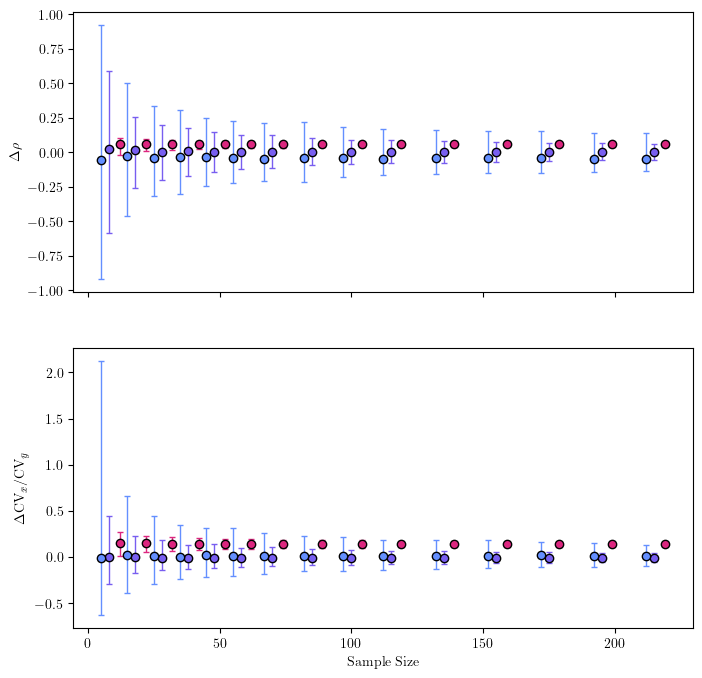

In [24]:
f,ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
example_plot(ax,nofb_analysis,colour=colours[0])
example_plot(ax,negfb_analysis,colour=colours[1])
example_plot(ax,posfb_analysis,colour=colours[2])
ax[0].set_ylabel(r'$\Delta \rho$')
ax[1].set_ylabel(r'$\Delta\mathrm{CV}_{\bar{x}}/\mathrm{CV}_{\bar{y}}$')
ax[1].set_xlabel(r'\textrm{Sample Size}')

Figure X: For the example systems shown in Figure 4, the difference between the linear prediction for the correlation (A) and the CV ratio (B) is plotted at a range of sample sizes. In all three cases we see improvements to the estimate in the CV ratio until around $10^3$ samples. This behaviour in the no feedback system (which by definition must convere to the linear prediction) suggests that numerical errors in simulation at this point dwarf the improvements in accuracy from better sampling of the independent perturbations. An estimate based on the no feedback system suggests that this point is at about a 1.4% difference: similar to the 1% and 5% error thresholds allowed on the estimates of averages and variances in the stochastic simulations. Markers represent the median difference between the predicted and sampled values, with error bars marking the 95% CI of the difference.

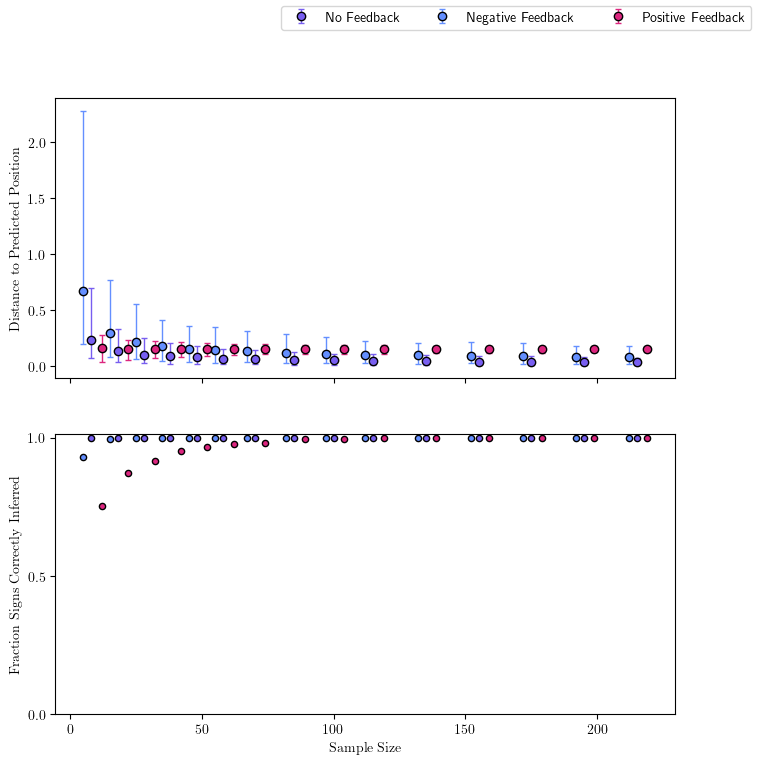

In [25]:
f,ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
a = ax[0].errorbar(nofb_analysis['samples'],nofb_analysis['E[distance to ref]'],
            yerr=[nofb_analysis['50% (distance to ref)']-nofb_analysis['2.5% (distance to ref)'],
                  nofb_analysis['97.5% (distance to ref)']-nofb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[0],label='No Feedback')
b = ax[0].errorbar(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
            yerr=[negfb_analysis['50% (distance to ref)']-negfb_analysis['2.5% (distance to ref)'],
                  negfb_analysis['97.5% (distance to ref)']-negfb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[1],label='Negative Feedback')
c = ax[0].errorbar(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
            yerr=[posfb_analysis['50% (distance to ref)']-posfb_analysis['2.5% (distance to ref)'],
                  posfb_analysis['97.5% (distance to ref)']-posfb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[2],label='Positive Feedback')

ax[1].scatter(nofb_analysis['samples'],nofb_analysis['Fy fraction correct'],
            color=colours[0],edgecolors='k',s=20)
ax[1].scatter(negfb_analysis['samples'],negfb_analysis['Fy fraction correct'],
            color=colours[1],edgecolors='k',s=20)
ax[1].scatter(posfb_analysis['samples'],posfb_analysis['Fy fraction correct'],
            color=colours[2],edgecolors='k',s=20)
               

f.legend([a,b,c],['No Feedback','Negative Feedback','Positive Feedback'],ncol=3)

ax[1].set_xlabel(r'\textrm{Sample Size}')
ax[0].set_ylabel(r'\textrm{Distance to Predicted Position}')
ax[1].set_ylabel(r'\textrm{Fraction Signs Correctly Inferred }')

ax[1].set_yticks([0,0.5,1])

Figure 4. Deviations from linear predictions in perturbation response due to finite sampling effects can be reduced by taking sample sizes of ~100 perturbations.

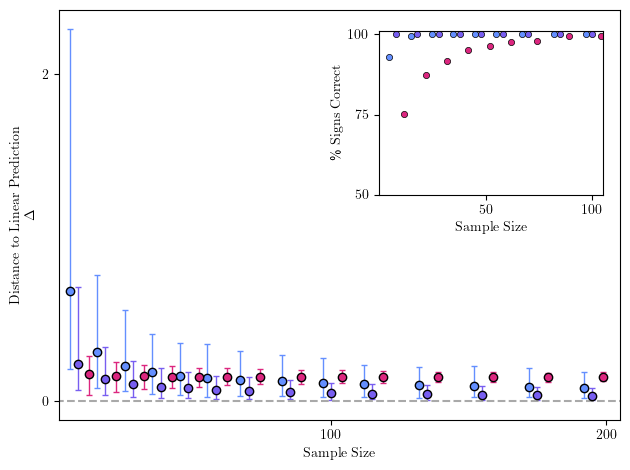

In [26]:
f,ax = plt.subplots()
a = ax.errorbar(nofb_analysis['samples'],nofb_analysis['E[distance to ref]'],
            yerr=[nofb_analysis['50% (distance to ref)']-nofb_analysis['2.5% (distance to ref)'],
                  nofb_analysis['97.5% (distance to ref)']-nofb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[0],label='No Feedback')
b = ax.errorbar(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
            yerr=[negfb_analysis['50% (distance to ref)']-negfb_analysis['2.5% (distance to ref)'],
                  negfb_analysis['97.5% (distance to ref)']-negfb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[1],label='Negative Feedback')
c = ax.errorbar(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
            yerr=[posfb_analysis['50% (distance to ref)']-posfb_analysis['2.5% (distance to ref)'],
                  posfb_analysis['97.5% (distance to ref)']-posfb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[2],label='Positive Feedback')


#plt.legend([a,b,c],[r'\textrm{No Feedback}',r'\textrm{Negative Feedback}',r'\textrm{Positive Feedback}'],loc=(0.05,0.75))

inset = ax.inset_axes([0.57,0.55,0.4,0.4])
inset.scatter(nofb_analysis['samples'],nofb_analysis['Fy fraction correct']*100,
              color=colours[0],edgecolors='k',s=20,linewidth=0.5,marker='o')
inset.scatter(negfb_analysis['samples'],negfb_analysis['Fy fraction correct']*100,
                color=colours[1],edgecolors='k',s=20,linewidth=0.5,marker='o')
inset.scatter(posfb_analysis['samples'],posfb_analysis['Fy fraction correct']*100,
                color=colours[2],edgecolors='k',s=20,linewidth=0.5,marker='o')
inset.set_xticks([50,100])
inset.set_yticks([50,75,100])
inset.set_xlabel(r'\textrm{Sample Size}')
inset.set_ylabel(r'\% \textrm{Signs Correct}')
inset.set_xlim(0,105)


ax.set_xticks([0,100,200])
ax.set_yticks([0,2])
ax.set_xlabel(r'\textrm{Sample Size}')
ax.set_ylabel(r'$\textrm{Distance to Linear Prediction}$'"\n"r"$\Delta$")
ax.set_xlim(1,205)
ax.grid(False)
ax.hlines(0,0,205,linestyles='dashed',colors='darkgrey')
inset.grid(False)
f.tight_layout()
#f.savefig('figures/April30_onwards/FiniteSampleEffects_graph.svg')

bootstrapped_sizes = np.logspace(1,6,6,base=10,dtype=int)
samplesizes = np.arange(10,160,10)
pos = multi_bootstrap(example_posfb,n_boots=bootstrapped_sizes,samplesizes = samplesizes)
neg = multi_bootstrap(example_negfb,n_boots=bootstrapped_sizes,samplesizes = samplesizes)
nof = multi_bootstrap(example_nofb,n_boots=bootstrapped_sizes,samplesizes = samplesizes)
plt.pcolor(np.log10(pos.unstack()['Fy fraction correct'].columns.to_list()),
           pos.unstack()['Fy fraction correct'].index.to_list(),
           pos.unstack()['Fy fraction correct'],
           cmap='viridis')
plt.colorbar(label='Fraction of Correct Replicates')

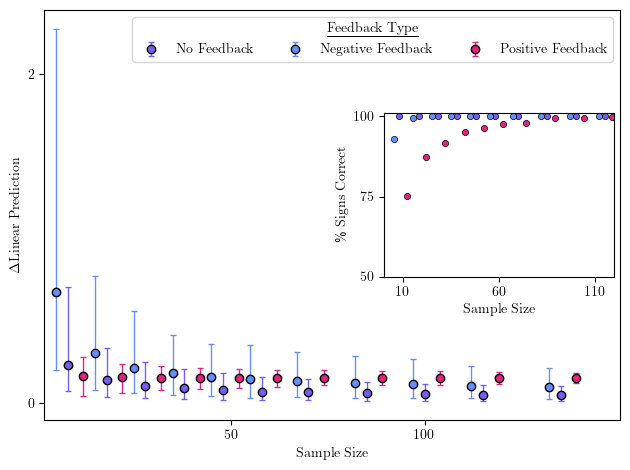

In [27]:
f,ax = plt.subplots()
a = ax.errorbar(nofb_analysis['samples'],nofb_analysis['E[distance to ref]'],
            yerr=[nofb_analysis['50% (distance to ref)']-nofb_analysis['2.5% (distance to ref)'],
                  nofb_analysis['97.5% (distance to ref)']-nofb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[0],label='No Feedback')
b = ax.errorbar(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
            yerr=[negfb_analysis['50% (distance to ref)']-negfb_analysis['2.5% (distance to ref)'],
                  negfb_analysis['97.5% (distance to ref)']-negfb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[1],label='Negative Feedback')
c = ax.errorbar(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
            yerr=[posfb_analysis['50% (distance to ref)']-posfb_analysis['2.5% (distance to ref)'],
                  posfb_analysis['97.5% (distance to ref)']-posfb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[2],label='Positive Feedback')


plt.legend([a,b,c],[r'\textrm{No Feedback}',r'\textrm{Negative Feedback}',r'\textrm{Positive Feedback}'],
           title=r'\underline{\textrm{Feedback Type}}',fancybox=True,ncols=3)

inset = ax.inset_axes([0.59,0.35,0.4,0.4])
inset.scatter(nofb_analysis['samples'],nofb_analysis['Fy fraction correct']*100,
              color=colours[0],edgecolors='k',s=20,linewidth=0.5,marker='o')
inset.scatter(negfb_analysis['samples'],negfb_analysis['Fy fraction correct']*100,
                color=colours[1],edgecolors='k',s=20,linewidth=0.5,marker='o')
inset.scatter(posfb_analysis['samples'],posfb_analysis['Fy fraction correct']*100,
                color=colours[2],edgecolors='k',s=20,linewidth=0.5,marker='o')
inset.set_xticks([10,60,110])
inset.set_yticks([50,75,100])
inset.set_xlabel(r'\textrm{Sample Size}')
inset.set_ylabel(r'\% \textrm{Signs Correct}')
inset.set_xlim(0,120)

ax.set_xticks([0,50,100])
ax.set_yticks([0,2])
ax.set_xlabel(r'\textrm{Sample Size}')
ax.set_ylabel(r'$\Delta\textrm{Linear Prediction}$')
ax.set_xlim(2,150.3)
f.tight_layout()
#f.savefig('figures/FiniteSampleEffects_graph_with_legend.svg')

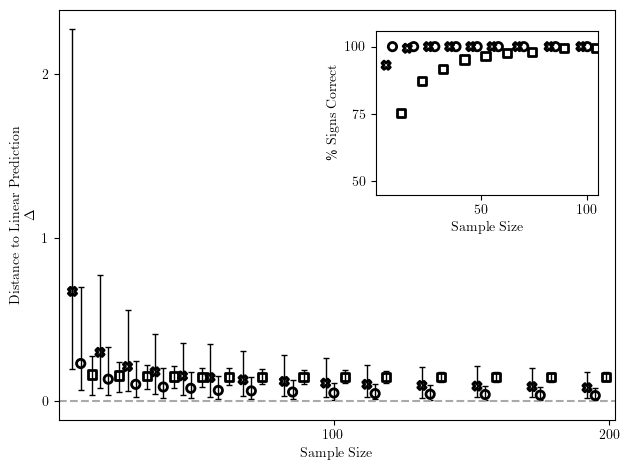

In [28]:
f,ax = plt.subplots()
a = ax.errorbar(nofb_analysis['samples'],nofb_analysis['E[distance to ref]'],
            yerr=[nofb_analysis['50% (distance to ref)']-nofb_analysis['2.5% (distance to ref)'],
                  nofb_analysis['97.5% (distance to ref)']-nofb_analysis['50% (distance to ref)']],
            fmt='none',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c='k',label='No Feedback')
a_dots = ax.scatter(nofb_analysis['samples'],nofb_analysis['E[distance to ref]'],
            color='None',edgecolors='k',linewidth=2,marker='o',zorder=4)


b = ax.errorbar(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
            yerr=[negfb_analysis['50% (distance to ref)']-negfb_analysis['2.5% (distance to ref)'],
                  negfb_analysis['97.5% (distance to ref)']-negfb_analysis['50% (distance to ref)']],
            fmt='none',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c='k',label='Negative Feedback')
#b_dots = ax.scatter(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
#            color='white',edgecolors='#648fff',linewidth=0.5,marker='v',zorder=3,hatch='\\\\\\\\')
b_dots_2 = ax.scatter(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
            color='None',edgecolors='k',linewidth=2,marker='X',zorder=4)

c = ax.errorbar(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
            yerr=[posfb_analysis['50% (distance to ref)']-posfb_analysis['2.5% (distance to ref)'],
                  posfb_analysis['97.5% (distance to ref)']-posfb_analysis['50% (distance to ref)']],
            fmt='none',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c='k',label='Positive Feedback')
#c_dots = ax.scatter(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
#            color='white',edgecolors='#dc267f',linewidth=0.5,marker='s',zorder=3,hatch='||||')
c_dots_2 = ax.scatter(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
            color='None',edgecolors='k',linewidth=2,marker='s',zorder=4)


#plt.legend([a,b,c],[r'\textrm{No Feedback}',r'\textrm{Negative Feedback}',r'\textrm{Positive Feedback}'],loc=(0.05,0.75))

inset = ax.inset_axes([0.57,0.55,0.4,0.4])
inset.scatter(nofb_analysis['samples'],nofb_analysis['Fy fraction correct']*100,
              color='None',edgecolors='k',linewidth=2,marker='o')
inset.scatter(negfb_analysis['samples'],negfb_analysis['Fy fraction correct']*100,
                color='None',edgecolors='k',linewidth=2,marker='X')
inset.scatter(posfb_analysis['samples'],posfb_analysis['Fy fraction correct']*100,
                color='None',edgecolors='k',linewidth=2,marker='s')
inset.set_xticks([50,100])
inset.set_yticks([50,75,100])
inset.set_xlabel(r'\textrm{Sample Size}')
inset.set_ylabel(r'\% \textrm{Signs Correct}')
inset.set_xlim(0,105)
inset.set_ylim(45,106)


ax.set_xticks([100,200])
ax.set_yticks([0,1,2])
ax.set_xlabel(r'\textrm{Sample Size}')
ax.set_ylabel(r'$\textrm{Distance to Linear Prediction}$'"\n"r"$\Delta$")
ax.set_xlim(0,202)
ax.grid(False)
ax.hlines(0,0,205,linestyles='dashed',colors='darkgrey')

inset.grid(False)

f.tight_layout()
#f.savefig('figures/April30_onwards/FiniteSampleEffects_graph.svg')

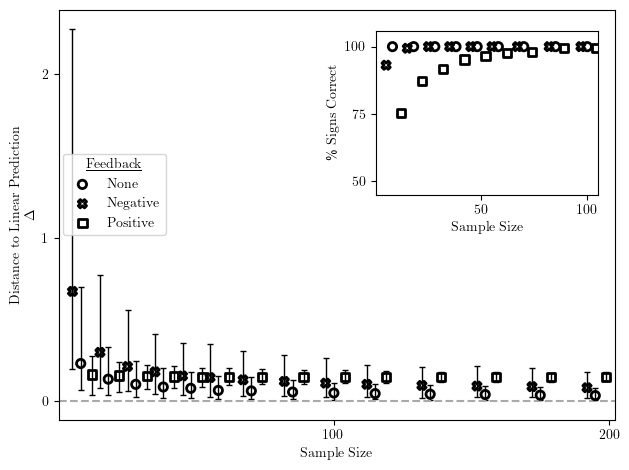

In [29]:
f,ax = plt.subplots()
a = ax.errorbar(nofb_analysis['samples'],nofb_analysis['E[distance to ref]'],
            yerr=[nofb_analysis['50% (distance to ref)']-nofb_analysis['2.5% (distance to ref)'],
                  nofb_analysis['97.5% (distance to ref)']-nofb_analysis['50% (distance to ref)']],
            fmt='none',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c='k',label='No Feedback')
a_dots = ax.scatter(nofb_analysis['samples'],nofb_analysis['E[distance to ref]'],
            color='None',edgecolors='k',linewidth=2,marker='o',zorder=4)


b = ax.errorbar(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
            yerr=[negfb_analysis['50% (distance to ref)']-negfb_analysis['2.5% (distance to ref)'],
                  negfb_analysis['97.5% (distance to ref)']-negfb_analysis['50% (distance to ref)']],
            fmt='none',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c='k',label='Negative Feedback')
#b_dots = ax.scatter(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
#            color='white',edgecolors='#648fff',linewidth=0.5,marker='v',zorder=3,hatch='\\\\\\\\')
b_dots_2 = ax.scatter(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
            color='None',edgecolors='k',linewidth=2,marker='X',zorder=4)

c = ax.errorbar(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
            yerr=[posfb_analysis['50% (distance to ref)']-posfb_analysis['2.5% (distance to ref)'],
                  posfb_analysis['97.5% (distance to ref)']-posfb_analysis['50% (distance to ref)']],
            fmt='none',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c='k',label='Positive Feedback')
#c_dots = ax.scatter(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
#            color='white',edgecolors='#dc267f',linewidth=0.5,marker='s',zorder=3,hatch='||||')
c_dots_2 = ax.scatter(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
            color='None',edgecolors='k',linewidth=2,marker='s',zorder=4)


#plt.legend([a,b,c],[r'\textrm{No Feedback}',r'\textrm{Negative Feedback}',r'\textrm{Positive Feedback}'],loc=(0.05,0.75))

inset = ax.inset_axes([0.57,0.55,0.4,0.4])
inset.scatter(nofb_analysis['samples'],nofb_analysis['Fy fraction correct']*100,
              color='None',edgecolors='k',linewidth=2,marker='o')
inset.scatter(negfb_analysis['samples'],negfb_analysis['Fy fraction correct']*100,
                color='None',edgecolors='k',linewidth=2,marker='X')
inset.scatter(posfb_analysis['samples'],posfb_analysis['Fy fraction correct']*100,
                color='None',edgecolors='k',linewidth=2,marker='s')
inset.set_xticks([50,100])
inset.set_yticks([50,75,100])
inset.set_xlabel(r'\textrm{Sample Size}')
inset.set_ylabel(r'\% \textrm{Signs Correct}')
inset.set_xlim(0,105)
inset.set_ylim(45,106)


ax.set_xticks([100,200])
ax.set_yticks([0,1,2])
ax.set_xlabel(r'\textrm{Sample Size}')
ax.set_ylabel(r'$\textrm{Distance to Linear Prediction}$'"\n"r"$\Delta$")
ax.set_xlim(0,202)
ax.grid(False)
ax.hlines(0,0,205,linestyles='dashed',colors='darkgrey')

inset.grid(False)

f.legend([a_dots,b_dots_2,c_dots_2],[r'\textrm{None}',r'\textrm{Negative}',r'\textrm{Positive}'],ncols=1,loc=(0.1,0.5),title=r'\underline{\textrm{Feedback}}')

f.tight_layout()
#f.savefig('figures/April30_onwards/FiniteSampleEffects_graph_withlegend.svg')

def boot_plot(ax,exampledata,markerlist=['d','s','p','H','o'],colour='b',Ndomain=np.logspace(-2,5,1000)):
    if len(markerlist) != len(exampledata.index.get_level_values(0).unique()):
        raise ValueError('Marker list must be same length as number of samples')
    ax.scatter(exampledata['cvref'],exampledata['rhoref'],marker='X',color=colour,edgecolors='k')
    ax.plot(lin_cvratio(1,Ndomain,exampledata['E[<F_y>]'].mean(),exampledata['E[<F_x>]'].mean()),lin_rho(1,Ndomain,exampledata['E[<F_y>]'].mean(),exampledata['E[<F_x>]'].mean()),color=colour,linestyle='dotted')
    ax.errorbar(exampledata['50% (CVx/CVy)'],exampledata['50% (rhoxy)'],
                xerr=[exampledata['50% (CVx/CVy)']-exampledata['2.5% (CVx/CVy)'],exampledata['97.5% (CVx/CVy)']-exampledata['50% (CVx/CVy)']],
                yerr=[exampledata['50% (rhoxy)']-exampledata['2.5% (rhoxy)'],exampledata['97.5% (rhoxy)']-exampledata['50% (rhoxy)']],
                fmt='',linestyle='',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,color=colour)
    for i,sample in enumerate(exampledata.index.get_level_values(0).unique()):
        ax.scatter(exampledata.loc[sample]['50% (CVx/CVy)'],
                   exampledata.loc[sample]['50% (rhoxy)'],
                   marker=markerlist[i],color=colour,edgecolors='k',zorder=10)



f,ax = plt.subplots()

boot_plot(ax,nofb_boot,colour=colours[0],markerlist=markerlist)
boot_plot(ax,negfb_boot,colour=colours[1],markerlist=markerlist)
boot_plot(ax,posfb_boot,colour=colours[2],markerlist=markerlist)
ax.plot(np.linspace(0,1),np.linspace(0,1),'k--')

fun = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

colourhandles = [fun("o", colours[i]) for i in range(len(colours))]
markerhandles = [fun(markerlist[i], "k") for i in range(len(markerlist))]
markerhandles.append(fun("X","k"))

ax.set_xlabel(r'$\mathrm{CV}_{\bar{x}}/\mathrm{CV}_{\bar{y}}$',size=25)
ax.set_ylabel(r'$\rho_{\bar{x}\bar{y}}$',size=25)


ax.set_xlim(0,1)
ax.set_ylim(0,1)

f.legend(colourhandles, colourlabels,loc='center right')
f.legend(markerhandles, markerlabels,loc='upper left')
f.tight_layout()


Figure 4: Three example systems with different types of feedback from the $y$-molecule to the transcription rate were simulated when perturbations to $\lambda$ and $\gamma$ were drawn from independent uniform distributions. For each system, the samples were bootstrapped to calculate the median values of $\rho_{\bar{x}\bar{y}}$ and $\mathrm{CV}_{\bar{x}}/\mathrm{CV}_{\bar{y}}$, and error bars denote the bootstrapped 95% CI. The number of drawn samples in each simulation is represented by the marker shape, with the cross representing where the linear theory predicts the system would land given the numerical values of $N$, $f_x$ and $f_y$. Dotted lines are overlaid to show where these systems would land across all $N$ for their calculated sensitivities. At very low sample numbers estimates can vary wildly due to the failure of the sampled distribution to meet the required statistical independence condition. In practice this would lead to many incorrect inferences on the sign of $f_y$, as evidenced by the error bars of small sample experiments crossing the constraint line in multiple directions. However, estimates based on order $10^2$ samples appear to give results that more consistently predict the correct feedback sign. In the case of the no feedback system, we in fact see them converging to the linear prediction as required. This suggests that to effectively use a variability-based linear theory a large, but experimentally achievable, number of samples from a distribution of perturbations would be required.

In [30]:
nofb_analysis

,samples,rhoref,cvref,E[rhoxy],2.5% (rhoxy),50% (rhoxy),97.5% (rhoxy),E[CVx/CVy],2.5% (CVx/CVy),50% (CVx/CVy),...,50% (|deltaCV|),97.5% (|deltaCV|),E[|deltarho|],2.5% (|deltarho|),50% (|deltarho|),E[distance to ref],2.5% (distance to ref),50% (distance to ref),97.5% (distance to ref),Fy fraction correct
8,8,0.705126,0.705126,0.683067,0.116231,0.730722,0.947369,0.720336,0.413348,0.702347,...,0.115789,0.444224,0.152589,0.005656,0.121895,0.231855,0.037415,0.197184,0.667003,1.0
18,18,0.705126,0.705126,0.702456,0.447033,0.717586,0.874911,0.710852,0.532142,0.703786,...,0.071730,0.244559,0.087575,0.003825,0.074107,0.136310,0.026991,0.126372,0.323057,1.0
28,28,0.705126,0.705126,0.700656,0.505628,0.708161,0.844198,0.705745,0.566461,0.698039,...,0.056552,0.189093,0.067149,0.002256,0.054011,0.104621,0.017628,0.095334,0.239844,1.0
38,38,0.705126,0.705126,0.701625,0.535026,0.709734,0.824009,0.697867,0.574427,0.694703,...,0.047500,0.157003,0.057559,0.001912,0.047938,0.088469,0.015725,0.081777,0.200419,1.0
48,48,0.705126,0.705126,0.702153,0.563078,0.704382,0.820457,0.702055,0.591116,0.696517,...,0.042659,0.139625,0.051993,0.001771,0.043810,0.080301,0.014731,0.075175,0.177048,1.0
58,58,0.705126,0.705126,0.701889,0.581565,0.705927,0.797613,0.693398,0.600587,0.689816,...,0.037480,0.118733,0.043627,0.001826,0.035542,0.067728,0.012606,0.063929,0.152925,1.0
70,70,0.705126,0.705126,0.702258,0.587723,0.706234,0.797107,0.698149,0.605153,0.696550,...,0.032083,0.115530,0.042649,0.001494,0.036516,0.064546,0.011731,0.059829,0.142647,1.0
85,85,0.705126,0.705126,0.705149,0.612476,0.707944,0.788105,0.697296,0.613685,0.695412,...,0.031622,0.100157,0.036463,0.001673,0.030239,0.057736,0.009992,0.054866,0.126063,1.0
100,100,0.705126,0.705126,0.702712,0.619437,0.704213,0.772984,0.696712,0.622729,0.694590,...,0.027564,0.090789,0.032842,0.001299,0.026838,0.051834,0.009074,0.050148,0.111087,1.0
115,115,0.705126,0.705126,0.703601,0.625702,0.704788,0.780076,0.696297,0.630514,0.695034,...,0.025110,0.082844,0.030738,0.001104,0.025868,0.048143,0.009597,0.045475,0.105334,1.0


In [31]:
example_nofb['gamma'].mean()

np.float64(2.0017910241935484)

In [32]:
import itertools

In [33]:
example_nofb['lambda']

sysname
12-18 1007/system_121    15.4895
12-18 1007/system_121    22.8879
12-18 1007/system_121    21.9594
12-18 1007/system_121    32.3968
12-18 1007/system_121    23.8782
                          ...   
12-18 1007/system_121    19.3864
12-18 1007/system_121    23.5519
12-18 1007/system_121    28.8315
12-18 1007/system_121    12.6876
12-18 1007/system_121    36.2023
Name: lambda, Length: 1240, dtype: float64

In [34]:
example_nofb[['beta_x','beta_y']]

,beta_x,beta_y
sysname,,
12-18 1007/system_121,0.1,1
12-18 1007/system_121,0.1,1
12-18 1007/system_121,0.1,1
12-18 1007/system_121,0.1,1
12-18 1007/system_121,0.1,1
...,...,...
12-18 1007/system_121,0.1,1
12-18 1007/system_121,0.1,1
12-18 1007/system_121,0.1,1


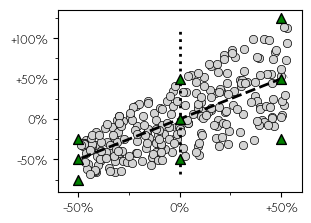

In [35]:
from matplotlib.font_manager import FontProperties
fontpath = '/Users/seshu/Library/Fonts/TorontoSubwayLight.otf'
labelfont = FontProperties(fname=fontpath,size=14)
plt.rcParams['text.usetex'] = False
f,ax = plt.subplots(1,1,figsize=(8/2.54,6/2.54))


rng = np.random.default_rng(0)
random_ex = example_nofb.sample(250,random_state=rng)
avgx = random_ex['<x>'].mean()
avgy = random_ex['<y>'].mean()
foldchangex = random_ex['<x>']/avgx - 1
foldchangey = random_ex['<y>']/avgy - 1
xbounds,ybounds = (np.min(foldchangex),np.max(foldchangex)),(np.min(foldchangey),np.max(foldchangey))

cartesian_lambdas = np.array([0.5,1,1.5])*25*0.001
cartesian_gammas = np.array([0.5,1,1.5])*2

cartx = []
carty = []
for l,g in itertools.product(cartesian_lambdas,cartesian_gammas):
    xvals = l/0.1
    yvals = g*xvals/1
    cartx.append(xvals)
    carty.append(yvals)

cartx = np.array(cartx).flatten()
carty = np.array(carty).flatten()
cart_foldx = cartx/np.mean(cartx) - 1
cart_foldy = carty/np.mean(carty) - 1


plt.scatter(foldchangex,foldchangey,edgecolors='k',facecolor='lightgray',linewidth=0.5)

plt.plot(np.linspace(*xbounds,100),np.linspace(*xbounds,100),c='k',linestyle='dashed',linewidth=2)
plt.plot(np.zeros(100),np.linspace(*ybounds,100),c='k',linestyle=':',linewidth=2)
plt.scatter(cart_foldx,cart_foldy,marker='^',
            edgecolors='k',facecolor='green',linewidth=1,s=50,zorder=5)

labelfont.set_size(10)
ax = plt.gca()
ax.set_xlim(-0.6,0.6)
ax.set_xticks([-0.5,0,0.5])
ax.set_xticklabels(['-50%','0%','+50%'],fontproperties=labelfont)
ax.set_xticks([-0.25,0.25],minor=True)


ax.set_ylim(-0.9,1.35)
ax.set_yticks([-0.5,0,0.5,1])
ax.set_yticklabels(['-50%','0%','+50%','+100%'],fontproperties=labelfont)
ax.set_yticks([-0.75,-0.25,0.25,0.75,1.25],minor=True)
#f.savefig('figures/Dec4/FiniteSampleEffects_foldchange.pdf')

In [36]:
cart_foldx

array([-0.5, -0.5, -0.5,  0. ,  0. ,  0. ,  0.5,  0.5,  0.5])

<Axes: >

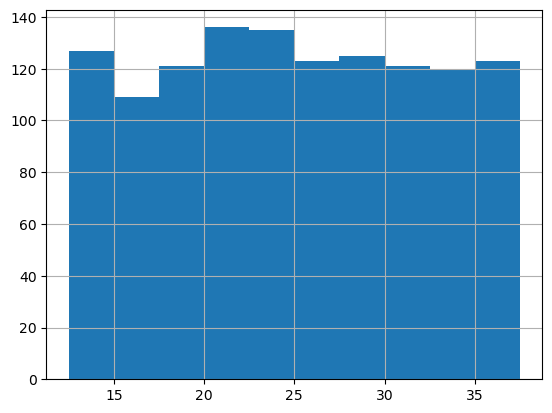

In [37]:
example_nofb['lambda'].hist()

In [38]:
cartx

array([0.125, 0.125, 0.125, 0.25 , 0.25 , 0.25 , 0.375, 0.375, 0.375])

In [39]:
pertdata.loc['12-18 1007/system_121']

,index,Exec Time,Sim Time,Steps,Flux Bal x,Flux Bal y,Cov Bal xx,Cov Bal xy,Cov Bal yy,lambda,...,Ky,offset,<x>,<y>,Var(x),Var(y),Cov(xy),<F_x>,<F_y>,samples
sysname,,,,,,,,,,,,,,,,,,,,,
12-18 1007/system_121,0,7134,64478400.0,49239500.0,0.000164,0.000055,0.007207,0.000330,0.000200,15.4895,...,10,0.001,0.154920,0.366308,0.156028,1.159460,0.335518,0.0,0.0,150.0
12-18 1007/system_121,1,6363,43760400.0,43863800.0,0.002713,0.000530,0.008844,0.002069,0.001056,22.8879,...,10,0.001,0.228259,0.478459,0.230600,1.401820,0.440099,0.0,0.0,150.0
12-18 1007/system_121,2,3425,45592200.0,23881600.0,0.000538,0.000061,0.010184,0.001520,0.000514,21.9594,...,10,0.001,0.219712,0.240072,0.221901,0.481570,0.220771,0.0,0.0,150.0
12-18 1007/system_121,3,8455,30835300.0,58167900.0,0.000121,0.000097,0.004557,0.000020,0.000305,32.3968,...,10,0.001,0.323929,0.910732,0.325428,3.247730,0.831672,0.0,0.0,150.0
12-18 1007/system_121,4,4156,41806300.0,28688200.0,0.002288,0.000344,0.009673,0.001021,0.000040,23.8782,...,10,0.001,0.239329,0.319052,0.241379,0.709721,0.292931,0.0,0.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-18 1007/system_121,20,5784,51510500.0,40105400.0,0.000764,0.000320,0.008107,0.000725,0.000346,19.3864,...,10,0.001,0.194012,0.369911,0.195517,1.016400,0.339028,0.0,0.0,25.0
12-18 1007/system_121,21,6718,42422300.0,46486200.0,0.001020,0.000046,0.010209,0.001001,0.000043,23.5519,...,10,0.001,0.235760,0.524393,0.238057,1.596200,0.481872,0.0,0.0,25.0
12-18 1007/system_121,22,6739,34698800.0,46636200.0,0.000734,0.000468,0.005966,0.001140,0.000459,28.8315,...,10,0.001,0.288527,0.643378,0.290147,1.955940,0.588568,0.0,0.0,25.0


In [107]:
param_corrs_mean = []
param_corrs_std = []
average_corrs_mean = []
average_corrs_std = []
CV_ratio_mean = []
CV_ratio_std = []
samplesizes = np.logspace(np.log10(5),np.log10(500),20,dtype=int)
samplesizes[-1] = 500
#samplesizes = [5,25,50,75,100,150,200,300,400,500]
number_reps = 100
stripplotdata = pd.DataFrame()
for i in samplesizes:
    paramcorr = []
    avgcorr = []
    CVratio = []
    for j in range(number_reps):
        sample = example_nofb.sample(n=i,replace=False,random_state=rng.integers(0,100000))
        paramcorr.append(sample[['lambda','gamma']].corr().iloc[0,1])
        avgcorr.append(sample[['<x>','<y>']].corr().iloc[0,1])
        CVratio.append((sample['<x>'].std(ddof=0)/sample['<x>'].mean())/(sample['<y>'].std(ddof=0)/sample['<y>'].mean()))
        stripplotdata = pd.concat([stripplotdata,pd.DataFrame({'Sample Size':i,'Parameter Correlation':paramcorr,
                                                                'Average Correlation':avgcorr,'CV Ratio':CVratio})],ignore_index=True)
    param_corrs_mean.append(np.mean(paramcorr))
    param_corrs_std.append(np.quantile(paramcorr,[0.025,0.975]))
    average_corrs_mean.append(np.mean(avgcorr))
    average_corrs_std.append(np.quantile(avgcorr,[0.025,0.975]))
    CV_ratio_mean.append(np.mean(CVratio))
    CV_ratio_std.append(np.quantile(CVratio,[0.025,0.975]))

In [108]:
stripplotdata

,Sample Size,Parameter Correlation,Average Correlation,CV Ratio
0,5,-0.687043,0.921044,1.437677
1,5,-0.687043,0.921044,1.437677
2,5,0.553397,0.886762,0.605148
3,5,-0.687043,0.921044,1.437677
4,5,0.553397,0.886762,0.605148
...,...,...,...,...
100995,500,0.019568,0.705981,0.698658
100996,500,0.001848,0.705079,0.709163
100997,500,0.028337,0.703954,0.690625
100998,500,0.036917,0.711018,0.686353


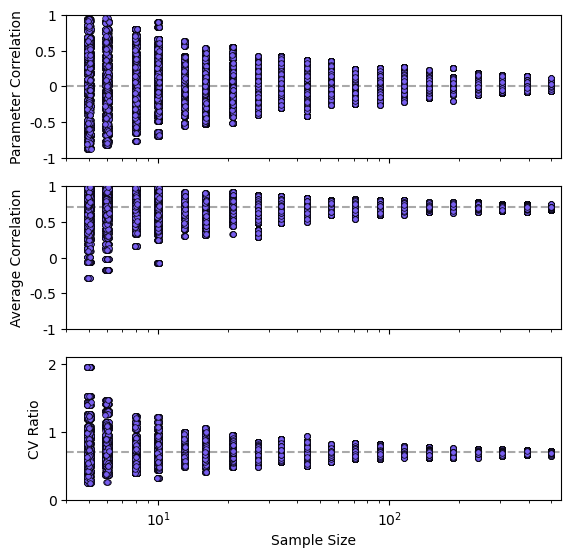

In [131]:
f,ax = plt.subplots(3,1,figsize=(16.2/2.54,16/2.54),sharex=True)

sns.stripplot(data=stripplotdata,x='Sample Size',y='Parameter Correlation',
              jitter=0.1,ax=ax[0],linewidth=0.5,edgecolor='k',size=4,native_scale=True,color='#785ef0')
sns.stripplot(data=stripplotdata,x='Sample Size',y='Average Correlation',
                jitter=0.1,ax=ax[1],linewidth=0.5,edgecolor='k',size=4,native_scale=True,color='#785ef0')
sns.stripplot(data=stripplotdata,x='Sample Size',y='CV Ratio',
                jitter=0.1,ax=ax[2],linewidth=0.5,edgecolor='k',size=4,native_scale=True,color='#785ef0')
ax[0].hlines(0,4,600,linestyles='dashed',colors='darkgrey')
ax[1].hlines(1/np.sqrt(2),4,600,linestyles='dashed',colors='darkgrey')
ax[2].hlines(1/np.sqrt(2),4,600,linestyles='dashed',colors='darkgrey')

ax[0].set_xscale('log')
ax[0].set_xlim(4,550)

ax[0].set_ylim(-1,1)
ax[0].set_yticks([-1,-0.5,0,0.5,1])
ax[0].set_yticklabels(['-1','-0.5','0','0.5','1'])

ax[1].set_ylim(-1,1)
ax[1].set_yticks([-1,-0.5,0,0.5,1])
ax[1].set_yticklabels(['-1','-0.5','0','0.5','1'])

ax[2].set_ylim(0,2.1)
ax[2].set_yticks([0,1,2])
ax[2].set_yticklabels(['0','1','2'])

#ax[0].set_ylabel(r'$\rho_{\lambda\gamma}$')
#ax[1].set_ylabel(r'$\rho_{\bar{x}\bar{y}}$')
#ax[2].set_ylabel(r'$\mathrm{CV}_{\bar{x}}/\mathrm{CV}_{\bar{y}}$')

f.savefig('figures/Dec4/FiniteSampleEffects_stripplot.pdf')

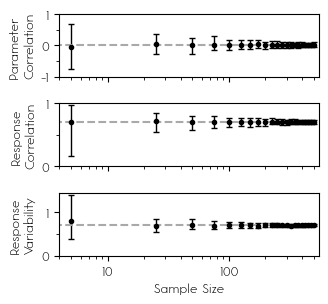

In [99]:
f,axs = plt.subplots(3,1,figsize=((8.6/2.54),(8/2.54)),sharex=True)
axs[0].errorbar(samplesizes,param_corrs_mean,yerr=[param_corrs_mean-np.array(param_corrs_std)[:,0],np.array(param_corrs_std)[:,1]-param_corrs_mean],
                fmt='.',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,markerfacecolor='k',color='k')
axs[1].errorbar(samplesizes,average_corrs_mean,yerr=[average_corrs_mean-np.array(average_corrs_std)[:,0],np.array(average_corrs_std)[:,1]-average_corrs_mean],
                fmt='.',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,markerfacecolor='k',color='k')
axs[2].errorbar(samplesizes,CV_ratio_mean,yerr=[CV_ratio_mean-np.array(CV_ratio_std)[:,0],np.array(CV_ratio_std)[:,1]-CV_ratio_mean],
                fmt='.',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,markerfacecolor='k',color='k')


axs[0].hlines(0,0,600,linestyles='dashed',colors='darkgrey')
axs[1].hlines(1/np.sqrt(2),0,600,linestyles='dashed',colors='darkgrey')
axs[2].hlines(1/np.sqrt(2),0,6000,linestyles='dashed',colors='darkgrey')

axs[0].set_yticks([-1,0,1])
axs[0].set_yticklabels(['-1','0','1'],fontproperties=labelfont)
axs[0].set_yticks([-0.5,0.5],minor=True)
axs[0].set_ylim(-1,1)

axs[1].set_yticks([0,1])
axs[1].set_yticklabels(['0','1'],fontproperties=labelfont)
axs[1].set_yticks([0.5],minor=True)
axs[1].set_ylim(0,1)

axs[2].set_yticks([0,1])
axs[2].set_yticklabels(['0','1'],fontproperties=labelfont)
axs[2].set_yticks([0.5],minor=True)


axs[2].set_xscale('log')
axs[2].set_xticks([1,10,100])
axs[2].set_xticklabels(['1','10','100'],fontproperties=labelfont)
axs[2].set_xlim(4,550)

axs[0].set_ylabel('Parameter \nCorrelation',fontproperties=labelfont)
axs[1].set_ylabel('Response \nCorrelation',fontproperties=labelfont)
axs[2].set_ylabel('Response \nVariability',fontproperties=labelfont)
axs[2].set_xlabel('Sample Size',fontproperties=labelfont)

f.tight_layout()
#f.savefig('figures/Dec9/FiniteSampleEffects_correlations.pdf')

In [59]:
sns.stripplot(x=samplesizes,y=paramcorr)

ValueError: All arrays must be of the same length

In [43]:
len(samplesizes)

10

<Axes: >

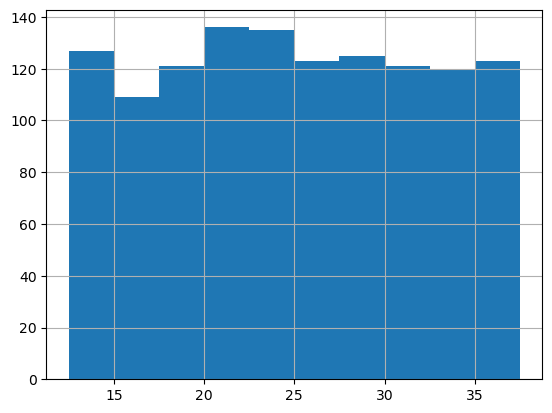

In [44]:
pertdata.loc['12-18 1007/system_121']['lambda'].hist()

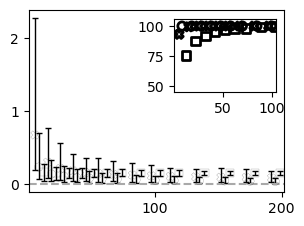

In [45]:
f,ax = plt.subplots(figsize=(8/2.54,6/2.54))
a = ax.errorbar(nofb_analysis['samples'],nofb_analysis['E[distance to ref]'],
            yerr=[nofb_analysis['50% (distance to ref)']-nofb_analysis['2.5% (distance to ref)'],
                  nofb_analysis['97.5% (distance to ref)']-nofb_analysis['50% (distance to ref)']],
            fmt='none',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c='k',label='No Feedback')
a_dots = ax.scatter(nofb_analysis['samples'],nofb_analysis['E[distance to ref]'],
            color='None',edgecolors='k',linewidth=0.1,marker='o',zorder=4)


b = ax.errorbar(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
            yerr=[negfb_analysis['50% (distance to ref)']-negfb_analysis['2.5% (distance to ref)'],
                  negfb_analysis['97.5% (distance to ref)']-negfb_analysis['50% (distance to ref)']],
            fmt='none',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c='k',label='Negative Feedback')
#b_dots = ax.scatter(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
#            color='white',edgecolors='#648fff',linewidth=0.5,marker='v',zorder=3,hatch='\\\\\\\\')
b_dots_2 = ax.scatter(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
            color='None',edgecolors='k',linewidth=0.1,marker='X',zorder=4)

c = ax.errorbar(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
            yerr=[posfb_analysis['50% (distance to ref)']-posfb_analysis['2.5% (distance to ref)'],
                  posfb_analysis['97.5% (distance to ref)']-posfb_analysis['50% (distance to ref)']],
            fmt='none',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c='k',label='Positive Feedback')
#c_dots = ax.scatter(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
#            color='white',edgecolors='#dc267f',linewidth=0.5,marker='s',zorder=3,hatch='||||')
c_dots_2 = ax.scatter(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
            color='None',edgecolors='k',linewidth=0.1,marker='s',zorder=4)


#plt.legend([a,b,c],[r'\textrm{No Feedback}',r'\textrm{Negative Feedback}',r'\textrm{Positive Feedback}'],loc=(0.05,0.75))

inset = ax.inset_axes([0.57,0.55,0.4,0.4])
inset.scatter(nofb_analysis['samples'],nofb_analysis['Fy fraction correct']*100,
              color='None',edgecolors='k',linewidth=2,marker='o')
inset.scatter(negfb_analysis['samples'],negfb_analysis['Fy fraction correct']*100,
                color='None',edgecolors='k',linewidth=2,marker='X')
inset.scatter(posfb_analysis['samples'],posfb_analysis['Fy fraction correct']*100,
                color='None',edgecolors='k',linewidth=2,marker='s')
inset.set_xticks([50,100])
inset.set_yticks([50,75,100])
inset.set_xlim(0,105)
inset.set_ylim(45,106)


ax.set_xticks([100,200])
ax.set_yticks([0,1,2])
ax.set_xlim(0,202)
ax.grid(False)
ax.hlines(0,0,205,linestyles='dashed',colors='darkgrey')

inset.grid(False)

f.tight_layout()
#f.savefig('figures/April30_onwards/FiniteSampleEffects_graph_withlegend.svg')

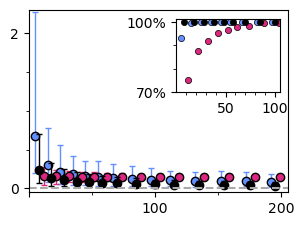

In [46]:
f,ax = plt.subplots(figsize=(8/2.54,6/2.54))
a = ax.errorbar(nofb_analysis['samples'],nofb_analysis['E[distance to ref]'],
            yerr=[nofb_analysis['50% (distance to ref)']-nofb_analysis['2.5% (distance to ref)'],
                  nofb_analysis['97.5% (distance to ref)']-nofb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c='k',label='No Feedback',zorder=1)
b = ax.errorbar(negfb_analysis['samples'],negfb_analysis['E[distance to ref]'],
            yerr=[negfb_analysis['50% (distance to ref)']-negfb_analysis['2.5% (distance to ref)'],
                  negfb_analysis['97.5% (distance to ref)']-negfb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[1],label='Negative Feedback',zorder=-1)
c = ax.errorbar(posfb_analysis['samples'],posfb_analysis['E[distance to ref]'],
            yerr=[posfb_analysis['50% (distance to ref)']-posfb_analysis['2.5% (distance to ref)'],
                  posfb_analysis['97.5% (distance to ref)']-posfb_analysis['50% (distance to ref)']],
            fmt='o',markeredgecolor='k',elinewidth=1,capsize=2,capthick=1,c=colours[2],label='Positive Feedback',zorder=-1)


#plt.legend([a,b,c],[r'\textrm{No Feedback}',r'\textrm{Negative Feedback}',r'\textrm{Positive Feedback}'],loc=(0.05,0.75))

inset = ax.inset_axes([0.57,0.55,0.4,0.4])
inset.scatter(nofb_analysis['samples'],nofb_analysis['Fy fraction correct']*100,
              color='k',edgecolors='k',s=20,linewidth=0.5,marker='o',zorder=1)
inset.scatter(negfb_analysis['samples'],negfb_analysis['Fy fraction correct']*100,
                color=colours[1],edgecolors='k',s=20,linewidth=0.5,marker='o',zorder=-1)
inset.scatter(posfb_analysis['samples'],posfb_analysis['Fy fraction correct']*100,
                color=colours[2],edgecolors='k',s=20,linewidth=0.5,marker='o',zorder=-1)
inset.set_xlim(0,105)
inset.set_xticks([50,100])
inset.set_xticklabels(['50','100'])
inset.set_xticks([10,20,30,40,60,70,80,90],minor=True)

inset.set_yticks([70,100])
inset.set_yticklabels(['70%','100%'])
inset.set_yticks([80,90],minor=True)



ax.set_xlim(1,205)
ax.set_ylim(-0.05,2.3)

ax.set_xticks([0,100,200])
ax.set_xticklabels(['','100','200'])
ax.set_xticks([50,150],minor=True)

ax.set_yticks([0,2])
ax.set_yticklabels(['0','2'])
ax.set_yticks([0.5,1,1.5],minor=True)


ax.hlines(0,0,205,linestyles='dashed',colors='darkgrey')
inset.grid(False)
f.tight_layout()
#f.savefig('figures/April30_onwards/FiniteSampleEffects_graph.svg')

In [47]:
example_nofb[['lambda','gamma']].mean()

lambda    24.990055
gamma      2.001791
dtype: float64

In [48]:
example_negfb[['lambda','gamma','ny','Ky','nx','Kx','offset']].mean()

lambda    24.994451
gamma      2.002430
ny        -1.000000
Ky        10.000000
nx         0.000000
Kx        10.000000
offset     0.001000
dtype: float64

In [49]:
example_nofb[['lambda','gamma','ny','Ky','nx','Kx','offset','beta_x','beta_y']].mean()

lambda    24.990055
gamma      2.001791
ny         0.000000
Ky        10.000000
nx         0.000000
Kx        10.000000
offset     0.001000
beta_x     0.100000
beta_y     1.000000
dtype: float64

In [50]:
example_nofb['<x>'].mean()

np.float64(0.24992587580645165)

In [51]:
25*0.001

0.025